In [ ]:
import numpy as np
import tensorflow as tf
import os
from os.path import isfile, join
import pandas as pd
import matplotlib.pylab as plt
from sklearn import preprocessing
import random

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/UAH-DRIVESET-v1'

In [ ]:
def get_dataset(data_path, shape, train_per = 0.7, val_per = 0.1, test_per = 0.2, shuffel = False, delta = False, overlapping = False, speedDelta = False):
    # initialize data variable as list
    X_train, Y_train, X_val, Y_val, X_test, Y_test = [], [], [], [], [], []

    for root, dirs, files in os.walk(data_path, topdown=False):
        if len(files) < 2:
            continue
        else:
            gps_df = get_data_list(root, shape, delta, overlapping, speedDelta)
            if shuffel:
                random.shuffle(gps_df)
            
            train_split_index = int(train_per * len(gps_df))
            val_split_index = int(val_per * len(gps_df)) + train_split_index

            X_train.extend(gps_df[: train_split_index])
            for i in range(train_split_index):
              Y_train.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

            X_val.extend(gps_df[train_split_index:val_split_index])
            for i in range(train_split_index, val_split_index):
              Y_val.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

            X_test.extend(gps_df[val_split_index:])
            for i in range(val_split_index, len(gps_df)):
              Y_test.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

    labels_columns = ["driver", "type", "road"]
    Y_train = pd.DataFrame(data= np.array(Y_train), columns=labels_columns)
    Y_val = pd.DataFrame(data= np.array(Y_val), columns=labels_columns)
    Y_test = pd.DataFrame(data= np.array(Y_test), columns=labels_columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

def get_generalized_dataset(data_path, shape, train_per = 0.7, val_per = 0.1, test_per = 0.2):
    # initialize data variable as list
    X_train, Y_train, X_val, Y_val, X_test, Y_test = [], [], [], [], [], []

    for root, dirs, files in os.walk(data_path, topdown=False):
        if len(files) < 2:
            continue
        else:
            gps_df = get_data_list(root, shape, False, False, False)
            
            # train_split_index = int(train_per * len(gps_df))
            # val_split_index = int(val_per * len(gps_df)) + train_split_index
            if root.split("/")[-1].split("-")[2] in ['D1', 'D2', 'D3', 'D4']:
                X_train.extend(gps_df)
                for i in range(len(gps_df)):
                    Y_train.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])
            elif root.split("/")[-1].split("-")[2] == 'D5':
                X_val.extend(gps_df)
                for i in range(len(gps_df)):
                    Y_val.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])
            elif root.split("/")[-1].split("-")[2] == 'D6':
                X_test.extend(gps_df)
                for i in range(len(gps_df)):
                    Y_test.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

    labels_columns = ["driver", "type", "road"]
    Y_train = pd.DataFrame(data= np.array(Y_train), columns=labels_columns)
    Y_val = pd.DataFrame(data= np.array(Y_val), columns=labels_columns)
    Y_test = pd.DataFrame(data= np.array(Y_test), columns=labels_columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

def get_data_list(root, shape, delta, overlapping, speedDelta):
    data_list = []
    gps_df = import_uah_trip_data(root)

    if delta:
        gps_df["delta_latitude"] = gps_df.latitude.diff()
        gps_df["delta_longitude"] = gps_df.longitude.diff()
        gps_df["delta_altitude"] = gps_df.altitude.diff()
        gps_df["delta_latitude"][0] = 0
        gps_df["delta_longitude"][0] = 0
        gps_df["delta_altitude"][0] = 0 
        gps_df["road_type"] = get_road_type(root)
    if speedDelta:
        if get_road_type(root) == 1:
            gps_df["delta_speed"] = 90 - gps_df["speed"]
        elif get_road_type(root) == 2:
            gps_df["delta_speed"] = 120 - gps_df["speed"]
    if overlapping:
        lenght = int(len(gps_df)-shape)
        for i in range(lenght):
            data_list.append(gps_df[i:i+shape])
    else:
        divisions = int(len(gps_df)/shape)
        gps_df = gps_df[:divisions * shape]
        for i in range(divisions):
            data_list.append(gps_df[shape * (i):shape * (i+1)])
    return data_list

def import_uah_trip_data(root_path):
    # import raw inertial data
    gps_file_path = os.path.join(root_path, "RAW_GPS.txt")
    gps_df = pd.read_csv(gps_file_path, sep=" ", header=None).iloc[:, 0:7]
    # add the column names
    gps_df.columns = [
        "timestamp",
        "speed",
        "latitude",
        "longitude",
        "altitude",
        "verticalAccuracy",
        "horizentalAccuracy",
    ]
    dataFrame = pd.DataFrame(data=gps_df, columns=gps_df.columns)
    return dataFrame

def get_trip_labels(file_path):
    if "NORMAL" in file_path:
        label = "NORMAL"
    elif "AGGRESSIVE" in file_path:
        label = "AGGRESSIVE"
    elif "DROWSY" in file_path:
        label = "DROWSY"
    else:
        label = None
    return label


def get_road_type(file_path):
    if "SECONDARY" in file_path:
        return 1
    elif "MOTORWAY" in file_path:
        return 2
    else:
        return None

def shuffling(X_train, Y_train_oh):
    indexes = np.arange(X_train.shape[0])
    np.random.shuffle(indexes)
    X_train = X_train[indexes,]
    Y_train_oh = Y_train_oh[indexes,]
    return X_train, Y_train_oh

In [ ]:
def normalization(X_train, X_val, X_test, type = 'min-max'):
    if type == 'min-max':
        for i in range(len(X_train[0,0])):
            train_min, train_max = X_train[:,0,i].min(),X_train[:,0,i].max() 
            X_train[:,0,i] = (X_train[:,0,i] - train_min)/(train_max - train_min)
            X_val[:,0,i] = (X_val[:,0,i] - train_min)/(train_max - train_min)
            X_test[:,0,i] = (X_test[:,0,i] - train_min)/(train_max - train_min)
    elif type == 'standardization':
        for i in range(len(X_train[0,0])):
            train_mean, train_std = X_train[:,0,i].mean(),X_train[:,0,i].std() 
            X_train[:,0,i] = (X_train[:,0,i] - train_mean)/train_std
            X_val[:,0,i] = (X_val[:,0,i] - train_mean)/train_std
            X_test[:,0,i] = (X_test[:,0,i] - train_mean)/train_std
    return X_train, X_val, X_test

In [ ]:
def oneHotEndcoding(Y_train, Y_val, Y_test):
    Y_train_oh = pd.get_dummies(Y_train.type, prefix='type')
    Y_val_oh = pd.get_dummies(Y_val.type, prefix='type')
    Y_test_oh = pd.get_dummies(Y_test.type, prefix='type')
    return Y_train_oh, Y_val_oh, Y_test_oh

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [ ]:
def my_model_cnn(ishape = (1,7), k = 3, lr = 1e-4, drop_out = 0.1, weight_decay = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    l1 = tf.keras.layers.Conv1D(32, 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(model_input)
    l1_batch = tf.keras.layers.BatchNormalization()(l1)
    l2 = tf.keras.layers.Conv1D(32, 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l1_batch)
    l2_batch = tf.keras.layers.BatchNormalization()(l2)
    l2_drop = tf.keras.layers.Dropout(drop_out)(l2_batch)
    l3 = tf.keras.layers.MaxPool1D(padding='same')(l2_drop)

    l4 = tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l3)
    l4_batch = tf.keras.layers.BatchNormalization()(l4)
    l5 = tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l4_batch)
    l5_batch = tf.keras.layers.BatchNormalization()(l5)
    l5_drop = tf.keras.layers.Dropout(2*drop_out)(l5_batch)
    l6 = tf.keras.layers.MaxPool1D(padding='same')(l5_drop)

    l7 = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l6)
    l7_batch = tf.keras.layers.BatchNormalization()(l7)
    l8 = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l7_batch)
    l8_batch = tf.keras.layers.BatchNormalization()(l8)
    l8_drop = tf.keras.layers.Dropout(3*drop_out)(l8_batch)
    l9 = tf.keras.layers.MaxPool1D(padding='same')(l8_drop)

    flat = tf.keras.layers.Flatten()(l9)
    out = tf.keras.layers.Dense(k, activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    opt_rms = tf.keras.optimizers.RMSprop(lr=lr,decay=1e-6)
    model.compile(optimizer=opt_rms, loss='categorical_crossentropy', metrics = ["accuracy", f1])
    
    return model

In [ ]:
model_name_cnn = "team_4_CNN.h5"
model_name_cnn_batched = "team_4_CNN_batched.h5"
model_name_cnn_with_delta_without_shuffel = "team_4_CNN__with_delta_without_shuffel.h5"
model_name_cnn_with_delta_with_shuffel = "team_4_CNN__with_delta_with_shuffel.h5"
model_name_cnn_with_delta_with_shuffel_batched = "team_4_CNN__with_delta_with_shuffel_batched.h5"
model_name_cnn_with_delta_with_shuffel_batched_overlaped = "team_4_CNN__with_delta_with_shuffel_batched_overlaped.h5"
model_name_cnn_with_delta_batched_overlaped = "team_4_CNN__with_delta_batched_overlaped.h5"
model_name_cnn_with_delta_with_correct_shuffel_batched_overlaped = "team_4_CNN__with_delta_with_correct_shuffel_batched_overlaped.h5"
model_name_cnn_with_delta_with_correct_shuffel_batched_overlaped = "team_4_CNN__with_delta_with_correct_shuffel_batched_overlaped.h5"
model_name_cnn_with_delta_with_shuffel_with_speed_delta = "team_4_CNN__with_delta_with_shuffel_with_speed_delta.h5"
model_name_cnn_general = "team_4_CNN__general.h5"
def callbacks(name):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 40)

    monitor = tf.keras.callbacks.ModelCheckpoint(name, monitor='val_loss',\
                                                verbose=0,save_best_only=True,\
                                                save_weights_only=True,\
                                                mode='min')
    # Learning rate schedule
    def scheduler(epoch, lr):
        if epoch%60 == 0:
            lr = lr/2
        return lr

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)
    
    return early_stop, monitor, lr_schedule

In [ ]:
shape = 1
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape=shape)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(21659, 1, 7)
(6231, 1, 7)
(3079, 1, 7)


In [ ]:
model_CNN = my_model_cnn()
early_stop, monitor, lr_schedule = callbacks(model_name_cnn)
print(model_CNN.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 7)]            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1, 32)             480       
_________________________________________________________________
batch_normalization_12 (Batc (None, 1, 32)             128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 32)             2080      
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 32)             128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 32)             0   

In [ ]:
history_CNN = model_CNN.fit(
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
677/677 [==============================] - 9s 10ms/step - loss: 1.4355 - accuracy: 0.4109 - f1: 0.3826 - val_loss: 1.0785 - val_accuracy: 0.4898 - val_f1: 0.4539
Epoch 2/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.1690 - accuracy: 0.4822 - f1: 0.4539 - val_loss: 0.9792 - val_accuracy: 0.5414 - val_f1: 0.4949
Epoch 3/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0817 - accuracy: 0.5114 - f1: 0.4798 - val_loss: 0.9284 - val_accuracy: 0.5421 - val_f1: 0.5102
Epoch 4/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0311 - accuracy: 0.5235 - f1: 0.4975 - val_loss: 0.9166 - val_accuracy: 0.5391 - val_f1: 0.5255
Epoch 5/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0015 - accuracy: 0.5338 - f1: 0.5064 - val_loss: 0.7997 - val_accuracy: 0.6142 - val_f1: 0.5615
Epoch 6/1000
677/677 [==============================] - 6s 9ms/step - loss: 0.9749 - accuracy: 0.5401 - f1: 0.5129 - val_loss: 0.

Final loss (cross-entropy and accuracy and F1): [1.3370925188064575, 0.5116353631019592, 0.5082371234893799]


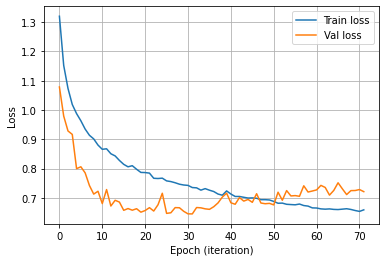

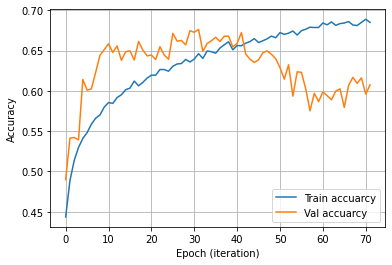

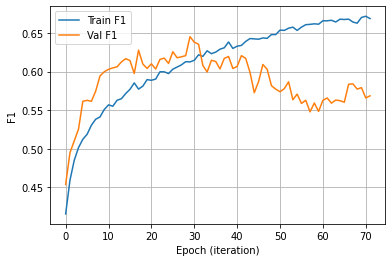

In [ ]:
model_CNN.load_weights(model_name_cnn)
loss_CNN = model_CNN.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_CNN)

plt.plot(history_CNN.history['loss'], label = "Train loss")
plt.plot(history_CNN.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN.history['f1'], label = "Train F1")
plt.plot(history_CNN.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 40
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape= shape)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(510, 40, 7)
(189, 40, 7)
(56, 40, 7)


In [ ]:
model_CNN_batched = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_batched)
print(model_CNN_batched.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40, 7)]           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 40, 32)            480       
_________________________________________________________________
batch_normalization_18 (Batc (None, 40, 32)            128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 40, 32)            2080      
_________________________________________________________________
batch_normalization_19 (Batc (None, 40, 32)            128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 20, 32)            0   

In [ ]:
history_CNN_batched = model_CNN_batched.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
16/16 [==============================] - 3s 34ms/step - loss: 1.7174 - accuracy: 0.3600 - f1: 0.3281 - val_loss: 1.7412 - val_accuracy: 0.2857 - val_f1: 0.2221
Epoch 2/1000
16/16 [==============================] - 0s 12ms/step - loss: 1.6812 - accuracy: 0.3642 - f1: 0.3240 - val_loss: 1.4615 - val_accuracy: 0.3929 - val_f1: 0.1526
Epoch 3/1000
16/16 [==============================] - 0s 12ms/step - loss: 1.5543 - accuracy: 0.4116 - f1: 0.3693 - val_loss: 1.4452 - val_accuracy: 0.3214 - val_f1: 0.2278
Epoch 4/1000
16/16 [==============================] - 0s 11ms/step - loss: 1.4396 - accuracy: 0.4107 - f1: 0.3742 - val_loss: 1.3882 - val_accuracy: 0.3036 - val_f1: 0.1854
Epoch 5/1000
16/16 [==============================] - 0s 12ms/step - loss: 1.5632 - accuracy: 0.3721 - f1: 0.3598 - val_loss: 1.3824 - val_accuracy: 0.3214 - val_f1: 0.2654
Epoch 6/1000
16/16 [==============================] - 0s 12ms/step - loss: 1.5998 - accuracy: 0.3834 - f1: 0.3447 - val_loss: 1.3280 - 

Final loss (cross-entropy and accuracy and F1): [1.7670557498931885, 0.30687829852104187, 0.31408512592315674]


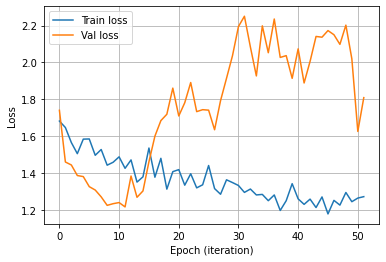

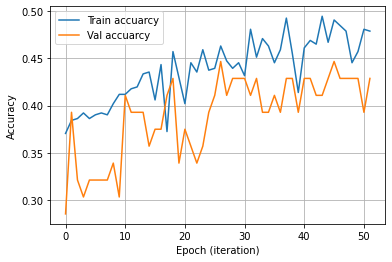

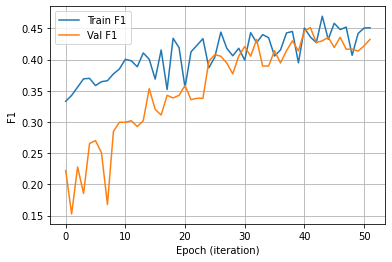

In [ ]:
model_CNN_batched.load_weights(model_name_cnn_batched)
loss_cnn_batched = model_CNN_batched.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn_batched)

plt.plot(history_CNN_batched.history['loss'], label = "Train loss")
plt.plot(history_CNN_batched.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_batched.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_batched.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_batched.history['f1'], label = "Train F1")
plt.plot(history_CNN_batched.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 1
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape=shape, delta = True)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(21659, 1, 11)
(6231, 1, 11)
(3079, 1, 11)


In [ ]:
model_CNN_with_delta_without_shuffel = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_with_delta_without_shuffel)
print(model_CNN_with_delta_without_shuffel.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 11)]           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1, 32)             736       
_________________________________________________________________
batch_normalization_24 (Batc (None, 1, 32)             128       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 1, 32)             2080      
_________________________________________________________________
batch_normalization_25 (Batc (None, 1, 32)             128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 32)             0   

In [ ]:
history_CNN_with_delta_without_shuffel = model_CNN_with_delta_without_shuffel.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
677/677 [==============================] - 9s 10ms/step - loss: 1.4731 - accuracy: 0.3784 - f1: 0.3459 - val_loss: 1.0360 - val_accuracy: 0.5538 - val_f1: 0.4930
Epoch 2/1000
677/677 [==============================] - 7s 10ms/step - loss: 1.2036 - accuracy: 0.4499 - f1: 0.4142 - val_loss: 0.9591 - val_accuracy: 0.5300 - val_f1: 0.4470
Epoch 3/1000
677/677 [==============================] - 7s 10ms/step - loss: 1.0845 - accuracy: 0.4905 - f1: 0.4576 - val_loss: 0.8882 - val_accuracy: 0.4745 - val_f1: 0.4293
Epoch 4/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0583 - accuracy: 0.5035 - f1: 0.4679 - val_loss: 0.8705 - val_accuracy: 0.4940 - val_f1: 0.4500
Epoch 5/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0198 - accuracy: 0.5232 - f1: 0.4925 - val_loss: 0.8704 - val_accuracy: 0.5177 - val_f1: 0.4563
Epoch 6/1000
677/677 [==============================] - 6s 10ms/step - loss: 0.9787 - accuracy: 0.5369 - f1: 0.5032 - val_loss:

Final loss (cross-entropy and accuracy and F1): [1.4619783163070679, 0.5138822197914124, 0.5102167725563049]


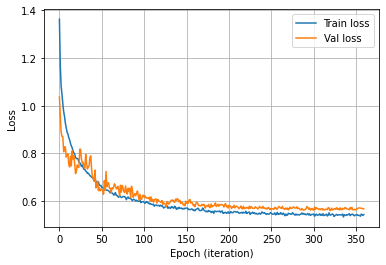

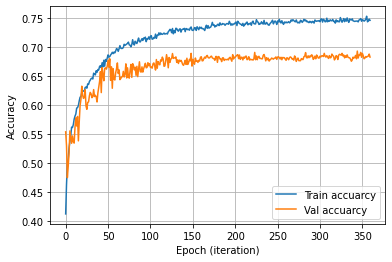

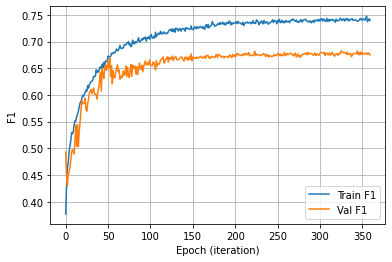

In [ ]:
model_CNN_with_delta_without_shuffel.load_weights(model_name_cnn_with_delta_without_shuffel)
loss_cnn__with_delta_without_shuffel = model_CNN_with_delta_without_shuffel.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn__with_delta_without_shuffel)

plt.plot(history_CNN_with_delta_without_shuffel.history['loss'], label = "Train loss")
plt.plot(history_CNN_with_delta_without_shuffel.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_with_delta_without_shuffel.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_with_delta_without_shuffel.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_with_delta_without_shuffel.history['f1'], label = "Train F1")
plt.plot(history_CNN_with_delta_without_shuffel.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 1
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape=shape, delta = True, shuffel=True)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(21659, 1, 11)
(6231, 1, 11)
(3079, 1, 11)


In [ ]:
model_CNN_with_delta_with_shuffel = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_with_delta_with_shuffel)
print(model_CNN_with_delta_with_shuffel.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1, 11)]           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 1, 32)             736       
_________________________________________________________________
batch_normalization_30 (Batc (None, 1, 32)             128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 1, 32)             2080      
_________________________________________________________________
batch_normalization_31 (Batc (None, 1, 32)             128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1, 32)             0   

In [ ]:
history_CNN_with_delta_with_shuffel = model_CNN_with_delta_with_shuffel.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
677/677 [==============================] - 9s 9ms/step - loss: 1.4798 - accuracy: 0.4009 - f1: 0.3726 - val_loss: 0.8737 - val_accuracy: 0.5609 - val_f1: 0.5045
Epoch 2/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.1941 - accuracy: 0.4652 - f1: 0.4348 - val_loss: 0.8151 - val_accuracy: 0.5905 - val_f1: 0.5511
Epoch 3/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0940 - accuracy: 0.4926 - f1: 0.4633 - val_loss: 0.7794 - val_accuracy: 0.6054 - val_f1: 0.5606
Epoch 4/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0428 - accuracy: 0.5063 - f1: 0.4812 - val_loss: 0.7623 - val_accuracy: 0.6197 - val_f1: 0.5704
Epoch 5/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0045 - accuracy: 0.5222 - f1: 0.4972 - val_loss: 0.7444 - val_accuracy: 0.6301 - val_f1: 0.5915
Epoch 6/1000
677/677 [==============================] - 6s 9ms/step - loss: 0.9831 - accuracy: 0.5282 - f1: 0.5006 - val_loss: 0.7

Final loss (cross-entropy and accuracy and F1): [0.5174863338470459, 0.7767613530158997, 0.7608655691146851]


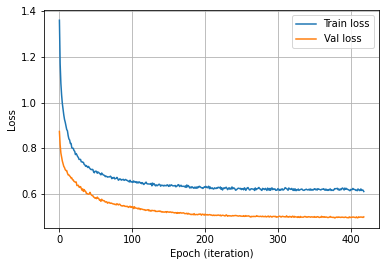

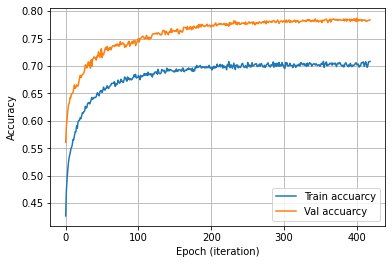

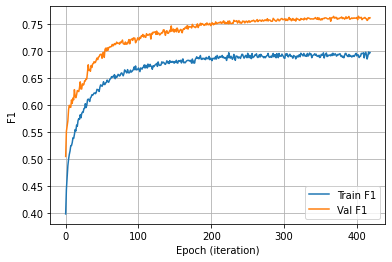

In [ ]:
model_CNN_with_delta_with_shuffel.load_weights(model_name_cnn_with_delta_with_shuffel)
loss_cnn__with_delta_with_shuffel = model_CNN_with_delta_with_shuffel.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn__with_delta_with_shuffel)

plt.plot(history_CNN_with_delta_with_shuffel.history['loss'], label = "Train loss")
plt.plot(history_CNN_with_delta_with_shuffel.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_with_delta_with_shuffel.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_with_delta_with_shuffel.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_with_delta_with_shuffel.history['f1'], label = "Train F1")
plt.plot(history_CNN_with_delta_with_shuffel.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 40
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape=shape, delta = True, shuffel=True)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(510, 40, 11)
(189, 40, 11)
(56, 40, 11)


In [ ]:
model_CNN_with_delta_with_shuffel_batched = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_with_delta_with_shuffel_batched)
print(model_CNN_with_delta_with_shuffel_batched.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 40, 11)]          0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 40, 32)            736       
_________________________________________________________________
batch_normalization_36 (Batc (None, 40, 32)            128       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 40, 32)            2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 40, 32)            128       
_________________________________________________________________
dropout_18 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 20, 32)            0   

In [ ]:
history_CNN_with_delta_with_shuffel_batched = model_CNN_with_delta_with_shuffel_batched.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
16/16 [==============================] - 3s 36ms/step - loss: 1.6938 - accuracy: 0.3592 - f1: 0.3265 - val_loss: 1.2377 - val_accuracy: 0.1786 - val_f1: 0.0911
Epoch 2/1000
16/16 [==============================] - 0s 10ms/step - loss: 1.7371 - accuracy: 0.3492 - f1: 0.3365 - val_loss: 1.1745 - val_accuracy: 0.2321 - val_f1: 0.0000e+00
Epoch 3/1000
16/16 [==============================] - 0s 11ms/step - loss: 1.5677 - accuracy: 0.4169 - f1: 0.4030 - val_loss: 1.1563 - val_accuracy: 0.2143 - val_f1: 0.0000e+00
Epoch 4/1000
16/16 [==============================] - 0s 12ms/step - loss: 1.5357 - accuracy: 0.4379 - f1: 0.4185 - val_loss: 1.1628 - val_accuracy: 0.3214 - val_f1: 0.0000e+00
Epoch 5/1000
16/16 [==============================] - 0s 11ms/step - loss: 1.5797 - accuracy: 0.3849 - f1: 0.3617 - val_loss: 1.1740 - val_accuracy: 0.3393 - val_f1: 0.0623
Epoch 6/1000
16/16 [==============================] - 0s 11ms/step - loss: 1.5443 - accuracy: 0.3821 - f1: 0.3443 - val_los

Final loss (cross-entropy and accuracy and F1): [0.9429110288619995, 0.5343915224075317, 0.5087500214576721]


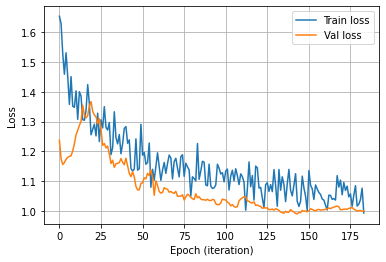

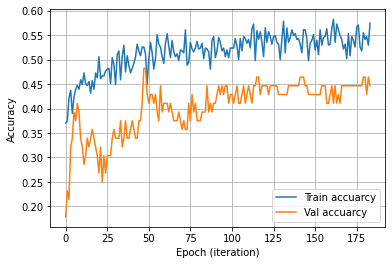

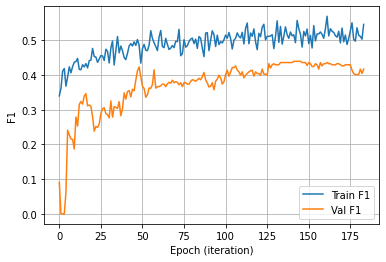

In [ ]:
model_CNN_with_delta_with_shuffel_batched.load_weights(model_name_cnn_with_delta_with_shuffel_batched)
loss_cnn__with_delta_with_shuffel_batched = model_CNN_with_delta_with_shuffel_batched.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn__with_delta_with_shuffel_batched)

plt.plot(history_CNN_with_delta_with_shuffel_batched.history['loss'], label = "Train loss")
plt.plot(history_CNN_with_delta_with_shuffel_batched.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_with_delta_with_shuffel_batched.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_with_delta_with_shuffel_batched.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_with_delta_with_shuffel_batched.history['f1'], label = "Train F1")
plt.plot(history_CNN_with_delta_with_shuffel_batched.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 40
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape= shape, delta = True, overlapping=True)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(20541, 40, 11)
(5909, 40, 11)
(2919, 40, 11)


In [ ]:
model_CNN_with_delta_batched_overlaped = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_with_delta_batched_overlaped)
print(model_CNN_with_delta_batched_overlaped.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 40, 11)]          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 40, 32)            736       
_________________________________________________________________
batch_normalization_42 (Batc (None, 40, 32)            128       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 40, 32)            2080      
_________________________________________________________________
batch_normalization_43 (Batc (None, 40, 32)            128       
_________________________________________________________________
dropout_21 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 20, 32)            0   

In [ ]:
history_CNN_with_delta_batched_overlaped = model_CNN_with_delta_batched_overlaped.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
642/642 [==============================] - 8s 10ms/step - loss: 1.5409 - accuracy: 0.4123 - f1: 0.3868 - val_loss: 1.5189 - val_accuracy: 0.4546 - val_f1: 0.4375
Epoch 2/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.2542 - accuracy: 0.4778 - f1: 0.4561 - val_loss: 1.5564 - val_accuracy: 0.5673 - val_f1: 0.5550
Epoch 3/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.1289 - accuracy: 0.5125 - f1: 0.4881 - val_loss: 2.0125 - val_accuracy: 0.4241 - val_f1: 0.4175
Epoch 4/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.0655 - accuracy: 0.5264 - f1: 0.5033 - val_loss: 1.5275 - val_accuracy: 0.4317 - val_f1: 0.3996
Epoch 5/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.0280 - accuracy: 0.5338 - f1: 0.5108 - val_loss: 1.6161 - val_accuracy: 0.4875 - val_f1: 0.4683
Epoch 6/1000
642/642 [==============================] - 6s 9ms/step - loss: 0.9894 - accuracy: 0.5492 - f1: 0.5271 - val_loss: 2.

Final loss (cross-entropy and accuracy and F1): [4.887843132019043, 0.4696226119995117, 0.4422990083694458]


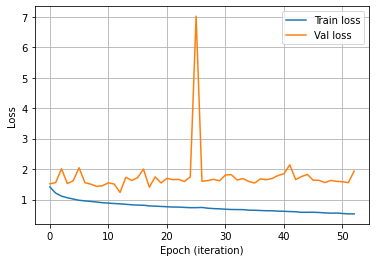

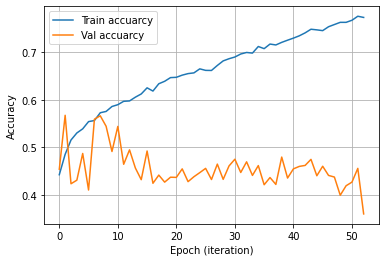

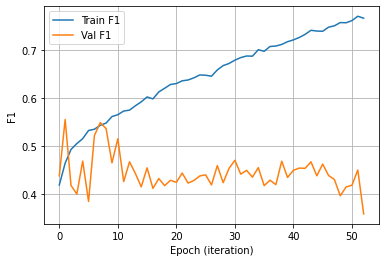

In [ ]:
model_CNN_with_delta_batched_overlaped.load_weights(model_name_cnn_with_delta_batched_overlaped)
loss_cnn__with_delta_batched_overlaped = model_CNN_with_delta_batched_overlaped.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn__with_delta_batched_overlaped)

plt.plot(history_CNN_with_delta_batched_overlaped.history['loss'], label = "Train loss")
plt.plot(history_CNN_with_delta_batched_overlaped.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_with_delta_batched_overlaped.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_with_delta_batched_overlaped.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_with_delta_batched_overlaped.history['f1'], label = "Train F1")
plt.plot(history_CNN_with_delta_batched_overlaped.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 40
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape= shape, delta = True, overlapping=True)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
Y_train_oh, Y_val_oh, Y_test_oh = np.array(Y_train_oh), np.array(Y_val_oh), np.array(Y_test_oh)
X_train, Y_train_oh = shuffling(X_train, Y_train_oh)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(20541, 40, 11)
(5909, 40, 11)
(2919, 40, 11)


In [ ]:
model_CNN_with_delta_with_correct_shuffel_batched_overlaped = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_with_delta_with_correct_shuffel_batched_overlaped)
print(model_CNN_with_delta_with_correct_shuffel_batched_overlaped.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 11)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 32)            736       
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 32)            2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 32)            0     

In [ ]:
history_CNN_with_delta_with_correct_shuffel_batched_overlaped = model_CNN_with_delta_with_correct_shuffel_batched_overlaped.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
642/642 [==============================] - 41s 11ms/step - loss: 1.5081 - accuracy: 0.4171 - f1: 0.3955 - val_loss: 1.7618 - val_accuracy: 0.3409 - val_f1: 0.3299
Epoch 2/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.2213 - accuracy: 0.4926 - f1: 0.4743 - val_loss: 1.6146 - val_accuracy: 0.4553 - val_f1: 0.4397
Epoch 3/1000
642/642 [==============================] - 6s 10ms/step - loss: 1.1141 - accuracy: 0.5204 - f1: 0.5018 - val_loss: 1.6516 - val_accuracy: 0.3251 - val_f1: 0.3132
Epoch 4/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.0507 - accuracy: 0.5362 - f1: 0.5152 - val_loss: 1.6763 - val_accuracy: 0.3419 - val_f1: 0.3350
Epoch 5/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.0210 - accuracy: 0.5479 - f1: 0.5213 - val_loss: 1.5550 - val_accuracy: 0.3460 - val_f1: 0.3373
Epoch 6/1000
642/642 [==============================] - 6s 10ms/step - loss: 1.0105 - accuracy: 0.5381 - f1: 0.5135 - val_loss:

Final loss (cross-entropy and accuracy and F1): [21.15226173400879, 0.25605008006095886, 0.2478632926940918]


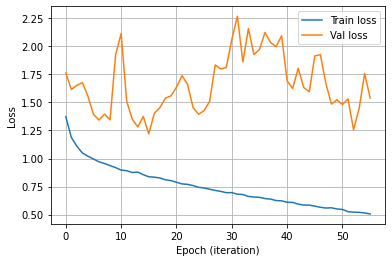

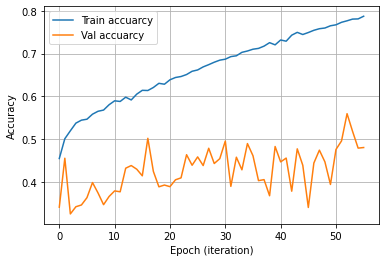

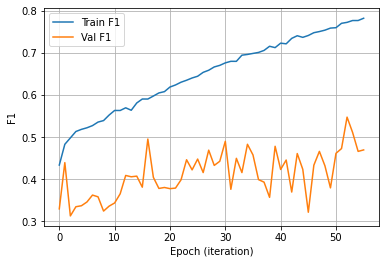

In [ ]:
model_CNN_with_delta_with_correct_shuffel_batched_overlaped.load_weights(model_name_cnn_with_delta_with_correct_shuffel_batched_overlaped)
loss_cnn__with_delta_with_correct_shuffel_batched_overlaped = model_CNN_with_delta_with_correct_shuffel_batched_overlaped.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn__with_delta_with_correct_shuffel_batched_overlaped)

plt.plot(history_CNN_with_delta_with_correct_shuffel_batched_overlaped.history['loss'], label = "Train loss")
plt.plot(history_CNN_with_delta_with_correct_shuffel_batched_overlaped.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_with_delta_with_correct_shuffel_batched_overlaped.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_with_delta_with_correct_shuffel_batched_overlaped.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_with_delta_with_correct_shuffel_batched_overlaped.history['f1'], label = "Train F1")
plt.plot(history_CNN_with_delta_with_correct_shuffel_batched_overlaped.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 40
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape= shape, delta = True, shuffel=True, overlapping=True)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(20541, 40, 11)
(5909, 40, 11)
(2919, 40, 11)


In [ ]:
model_CNN_with_delta_with_shuffel_batched_overlaped = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_with_delta_with_shuffel_batched_overlaped)
print(model_CNN_with_delta_with_shuffel_batched_overlaped.summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 40, 11)]          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 40, 32)            736       
_________________________________________________________________
batch_normalization_48 (Batc (None, 40, 32)            128       
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 40, 32)            2080      
_________________________________________________________________
batch_normalization_49 (Batc (None, 40, 32)            128       
_________________________________________________________________
dropout_24 (Dropout)         (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 20, 32)            0   

In [ ]:
history_CNN_with_delta_with_shuffel_batched_overlaped = model_CNN_with_delta_with_shuffel_batched_overlaped.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
642/642 [==============================] - 8s 10ms/step - loss: 1.5184 - accuracy: 0.4071 - f1: 0.3842 - val_loss: 1.0505 - val_accuracy: 0.5248 - val_f1: 0.5014
Epoch 2/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.2548 - accuracy: 0.4793 - f1: 0.4569 - val_loss: 1.0284 - val_accuracy: 0.5454 - val_f1: 0.5146
Epoch 3/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.1661 - accuracy: 0.4951 - f1: 0.4676 - val_loss: 0.9707 - val_accuracy: 0.5522 - val_f1: 0.5274
Epoch 4/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.1003 - accuracy: 0.5090 - f1: 0.4842 - val_loss: 0.9549 - val_accuracy: 0.5481 - val_f1: 0.5108
Epoch 5/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.0355 - accuracy: 0.5327 - f1: 0.5002 - val_loss: 0.9150 - val_accuracy: 0.5632 - val_f1: 0.5262
Epoch 6/1000
642/642 [==============================] - 6s 9ms/step - loss: 1.0150 - accuracy: 0.5387 - f1: 0.5061 - val_loss: 0.

Final loss (cross-entropy and accuracy and F1): [0.2759893238544464, 0.9196141362190247, 0.9187886714935303]


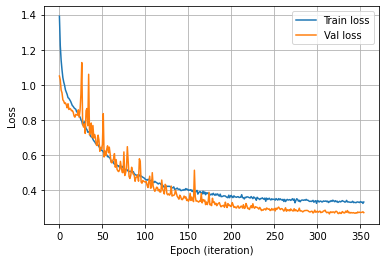

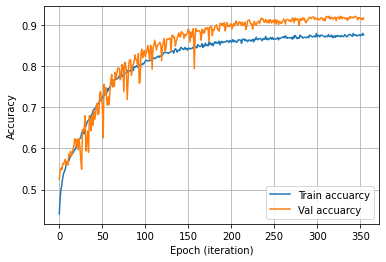

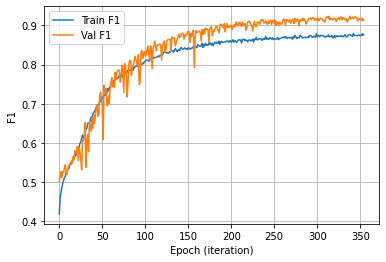

In [ ]:
model_CNN_with_delta_with_shuffel_batched_overlaped.load_weights(model_name_cnn_with_delta_with_shuffel_batched_overlaped)
loss_cnn__with_delta_with_shuffel_batched_overlaped = model_CNN_with_delta_with_shuffel_batched_overlaped.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn__with_delta_with_shuffel_batched_overlaped)

plt.plot(history_CNN_with_delta_with_shuffel_batched_overlaped.history['loss'], label = "Train loss")
plt.plot(history_CNN_with_delta_with_shuffel_batched_overlaped.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_with_delta_with_shuffel_batched_overlaped.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_with_delta_with_shuffel_batched_overlaped.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_with_delta_with_shuffel_batched_overlaped.history['f1'], label = "Train F1")
plt.plot(history_CNN_with_delta_with_shuffel_batched_overlaped.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 1
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder, shape= shape, delta = True, shuffel = True, speedDelta = True)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(21659, 1, 12)
(6231, 1, 12)
(3079, 1, 12)


In [ ]:
model_CNN_with_delta_with_shuffel_with_speed_delta = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_with_delta_with_shuffel_with_speed_delta)
print(model_CNN_with_delta_with_shuffel_with_speed_delta.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 12)]           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1, 32)             800       
_________________________________________________________________
batch_normalization_12 (Batc (None, 1, 32)             128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 32)             2080      
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 32)             128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 32)             0   

In [ ]:
history_CNN_with_delta_with_shuffel_with_speed_delta = model_CNN_with_delta_with_shuffel_with_speed_delta.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
677/677 [==============================] - 9s 10ms/step - loss: 1.4804 - accuracy: 0.3894 - f1: 0.3580 - val_loss: 0.8965 - val_accuracy: 0.5576 - val_f1: 0.4953
Epoch 2/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.1665 - accuracy: 0.4796 - f1: 0.4479 - val_loss: 0.8282 - val_accuracy: 0.5911 - val_f1: 0.5373
Epoch 3/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.1083 - accuracy: 0.4936 - f1: 0.4633 - val_loss: 0.8150 - val_accuracy: 0.5976 - val_f1: 0.5439
Epoch 4/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0711 - accuracy: 0.5024 - f1: 0.4744 - val_loss: 0.7893 - val_accuracy: 0.6064 - val_f1: 0.5544
Epoch 5/1000
677/677 [==============================] - 6s 9ms/step - loss: 1.0364 - accuracy: 0.5210 - f1: 0.4902 - val_loss: 0.7738 - val_accuracy: 0.6213 - val_f1: 0.5552
Epoch 6/1000
677/677 [==============================] - 6s 9ms/step - loss: 0.9968 - accuracy: 0.5276 - f1: 0.4948 - val_loss: 0.

Final loss (cross-entropy and accuracy and F1): [0.5057017207145691, 0.7666506171226501, 0.7501482963562012]


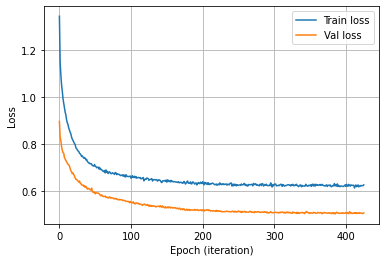

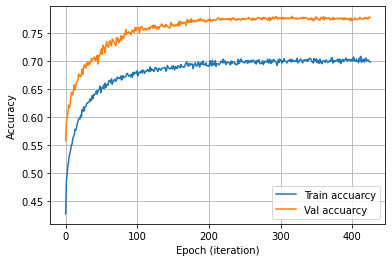

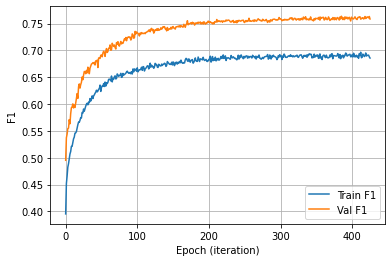

In [ ]:
model_CNN_with_delta_with_shuffel_with_speed_delta.load_weights(model_name_cnn_with_delta_with_shuffel_with_speed_delta)
loss_cnn__with_delta_with_shuffel_with_speed_delta = model_CNN_with_delta_with_shuffel_with_speed_delta.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn__with_delta_with_shuffel_with_speed_delta)

plt.plot(history_CNN_with_delta_with_shuffel_with_speed_delta.history['loss'], label = "Train loss")
plt.plot(history_CNN_with_delta_with_shuffel_with_speed_delta.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_with_delta_with_shuffel_with_speed_delta.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_with_delta_with_shuffel_with_speed_delta.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_with_delta_with_shuffel_with_speed_delta.history['f1'], label = "Train F1")
plt.plot(history_CNN_with_delta_with_shuffel_with_speed_delta.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()

In [ ]:
shape = 1
X_train, Y_train, X_val, Y_val, X_test, Y_test = get_generalized_dataset(data_folder, shape=shape)
X_train, X_val, X_test = normalization(X_train, X_val, X_test)
Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(21141, 1, 7)
(4529, 1, 7)
(5299, 1, 7)


In [ ]:
model_CNN_general = my_model_cnn(ishape=(len(X_train[0]), len(X_train[0,0])))
early_stop, monitor, lr_schedule = callbacks(model_name_cnn_general)
print(model_CNN_general.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 7)]            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1, 32)             480       
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 32)             128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 32)             2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 32)             128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 32)             0   

In [ ]:
history_CNN_general = model_CNN_general.fit(    
    X_train, 
    Y_train_oh, 
    batch_size = 32, 
    epochs = 1000, 
    verbose = 1, 
    callbacks=[early_stop, monitor, lr_schedule], 
    validation_data = (X_val, Y_val_oh)
)

Epoch 1/1000
661/661 [==============================] - 10s 11ms/step - loss: 1.4606 - accuracy: 0.3967 - f1: 0.3622 - val_loss: 0.8293 - val_accuracy: 0.5865 - val_f1: 0.4997
Epoch 2/1000
661/661 [==============================] - 6s 10ms/step - loss: 1.1895 - accuracy: 0.4737 - f1: 0.4468 - val_loss: 0.7543 - val_accuracy: 0.6145 - val_f1: 0.5494
Epoch 3/1000
661/661 [==============================] - 6s 9ms/step - loss: 1.0943 - accuracy: 0.4994 - f1: 0.4669 - val_loss: 0.7669 - val_accuracy: 0.5922 - val_f1: 0.5301
Epoch 4/1000
661/661 [==============================] - 6s 9ms/step - loss: 1.0622 - accuracy: 0.5082 - f1: 0.4784 - val_loss: 0.7573 - val_accuracy: 0.5948 - val_f1: 0.5314
Epoch 5/1000
661/661 [==============================] - 7s 10ms/step - loss: 1.0158 - accuracy: 0.5207 - f1: 0.4905 - val_loss: 0.7600 - val_accuracy: 0.5886 - val_f1: 0.5233
Epoch 6/1000
661/661 [==============================] - 6s 9ms/step - loss: 0.9874 - accuracy: 0.5353 - f1: 0.5034 - val_loss:

Final loss (cross-entropy and accuracy and F1): [1.2215205430984497, 0.47582247853279114, 0.44005995988845825]


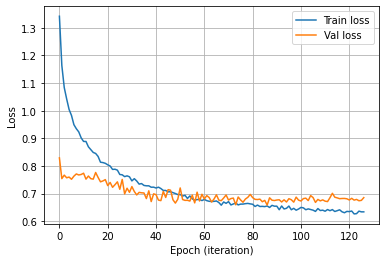

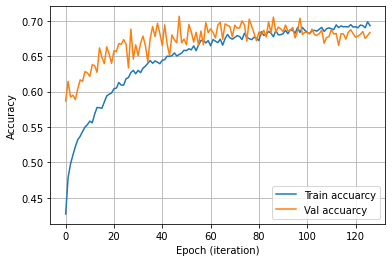

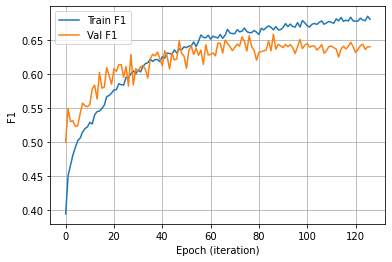

In [ ]:
model_CNN_general.load_weights(model_name_cnn_general)
loss_cnn__general = model_CNN_general.evaluate(X_test, Y_test_oh, verbose=0)
print('Final loss (cross-entropy and accuracy and F1):',loss_cnn__general)

plt.plot(history_CNN_general.history['loss'], label = "Train loss")
plt.plot(history_CNN_general.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history_CNN_general.history['accuracy'], label = "Train accuarcy")
plt.plot(history_CNN_general.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_CNN_general.history['f1'], label = "Train F1")
plt.plot(history_CNN_general.history['val_f1'], label = "Val F1")
plt.xlabel("Epoch (iteration)")
plt.ylabel("F1")
plt.legend()
plt.grid()
plt.show()